In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as st
from patsy import dmatrix

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### 19.2 Data generation

In [3]:
n_groups = 16
n_years = 10
n = n_groups * n_years
pop = np.repeat(range(1, n_groups + 1), n_years)

prec = st.uniform.rvs(0, 1, size = n)
N = np.round(st.uniform.rvs(10, 40, size = n)).astype(np.int)

data_ds = pd.DataFrame({'pop': pd.Series(pop, dtype = 'category'), 'prec': prec})
Xmat = dmatrix("~ pop * prec - 1 - prec", data_ds, return_type = 'dataframe')

intercept_mean = 1                       # Choose values for the hyperparams
intercept_sd = 1
slope_mean = -2
slope_sd = 1
intercept_effects = st.norm.rvs(intercept_mean, intercept_sd, size = n_groups)
slope_effects = st.norm.rvs(slope_mean, slope_sd, size = n_groups)
all_effects = np.concatenate((intercept_effects, slope_effects))

lin_pred = Xmat.to_numpy() @ all_effects
exp_p = np.exp(lin_pred) / (1 + np.exp(lin_pred))
C = st.binom.rvs(n = N, p = exp_p, size = n)


data = pd.DataFrame({'C': C, 'pop': pop, 'prec': prec, 'exp_p': exp_p, 'N': N})

**FIGURE 19.2**

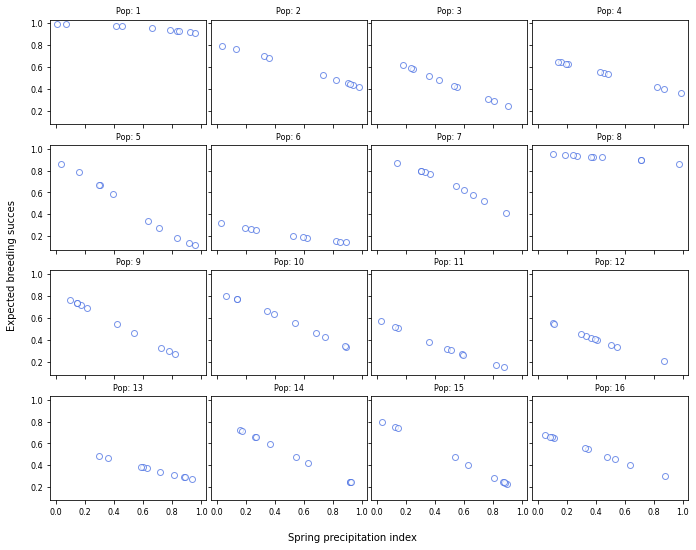

In [4]:
fig, axes = plt.subplots(4, 4, figsize=(10, 8), sharey=True, sharex=True)
fig.subplots_adjust(left=0.09, right=0.975, bottom=0.09, top=0.925, wspace=0.03)

axes_flat = axes.ravel()

for i, pop_ in enumerate(range(1, n_groups + 1)):
    ax = axes_flat[i]
    idx_ = data.index[data["pop"] == pop_].tolist()
    exp_p_ = data.loc[idx_, "exp_p"].values
    prec_ = data.loc[idx_, "prec"].values

    # Plot observed data points
    ax.scatter(prec_, exp_p_, color="white", ec="royalblue", alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=8)
    # Add a title
    ax.set_title(f"Pop: {pop_}", fontsize = 8)

fig.text(0.42, 0.02, "Spring precipitation index", fontsize = 10)
fig.text(0.03, 0.5, "Expected breeding succes", rotation = 90, fontsize = 10, va = "center");

**FIGURE 19.3**

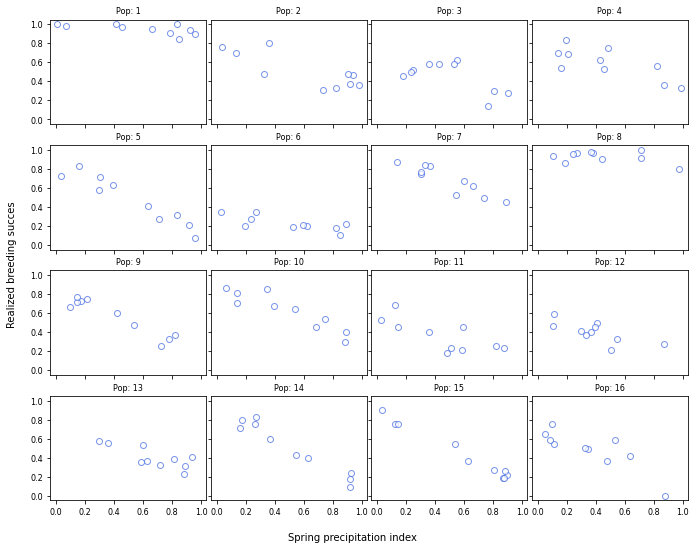

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(10, 8), sharey=True, sharex=True)
fig.subplots_adjust(left=0.09, right=0.975, bottom=0.09, top=0.925, wspace=0.03)

axes_flat = axes.ravel()

for i, pop_ in enumerate(range(1, n_groups + 1)):
    ax = axes_flat[i]
    idx_ = data.index[data["pop"] == pop_].tolist()
    C_ = data.loc[idx_, "C"].values
    N_ = data.loc[idx_, "N"].values
    prec_ = data.loc[idx_, "prec"].values

    # Plot observed data points
    ax.scatter(prec_, C_/N_, color="white", ec="royalblue", alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=8)
    # Add a title
    ax.set_title(f"Pop: {pop_}", fontsize = 8)

fig.text(0.42, 0.02, "Spring precipitation index", fontsize = 10)
fig.text(0.03, 0.5, "Realized breeding succes", rotation = 90, fontsize = 10, va = "center");

#### 19.3.2 Analysis using PyMC3

In [6]:
idx = pd.factorize(pop)[0]

In [7]:
with pm.Model() as model_19_3_2:
    
    mu_int = pm.Normal('mu_int', 0, tau = 0.001)
    sigma_int = pm.Uniform('sigma_int', 0, 10)
    mu_beta = pm.Normal('mu_beta', 0, tau = 0.001)
    sigma_beta = pm.Uniform('sigma_beta', 0, 10)
    
    alpha = pm.Normal('alpha', mu = mu_int, sigma = sigma_int, shape = n_groups)
    beta = pm.Normal('beta', mu = mu_beta, sigma  =sigma_beta, shape = n_groups) 
    p = pm.Deterministic('p', pm.math.invlogit(alpha[idx] + beta[idx] * prec))
   
    C_pred = pm.Binomial('C_new', n = N, p = p, observed = C)
    
    trace_19_3_2 = pm.sample(return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma_beta, mu_beta, sigma_int, mu_int]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.


In [8]:
az.summary(trace_19_3_2, var_names = ['~p', '~alpha', '~beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_int,1.395,0.331,0.795,2.085,0.007,0.005,2267.0,1015.0,1.00
mu_beta,-2.257,0.238,-2.680,-1.785,0.006,0.004,1865.0,1508.0,1.01
sigma_int,1.274,0.289,0.805,1.809,0.007,0.005,2419.0,1148.0,1.00
sigma_beta,0.737,0.225,0.348,1.161,0.008,0.005,808.0,1071.0,1.01


**EXERCISES** \
**1.** *Predictions*: Produce a plot of the mean expected response of breeding succes to the spring precipitation index. Try to overlay these estimates on the observed data.

In [9]:
p_post = trace_19_3_2.posterior.stack(samples = {'chain', 'draw'})['p'].values
data = pd.DataFrame({'C': C, 'pop': pop, 'prec': prec, 'exp_p': exp_p, 'N': N, 'p': p_post.mean(axis = 1)})

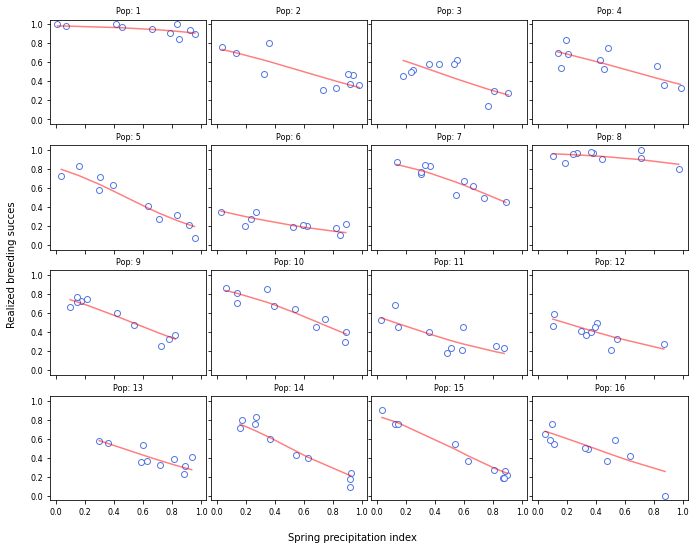

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(10, 8), sharey=True, sharex=True)
fig.subplots_adjust(left=0.09, right=0.975, bottom=0.09, top=0.925, wspace=0.03)

axes_flat = axes.ravel()

for i, pop_ in enumerate(range(1, n_groups + 1)):
    ax = axes_flat[i]
    idx_ = data.index[data["pop"] == pop_].tolist()
    C_ = data.loc[idx_, "C"].values
    N_ = data.loc[idx_, "N"].values
    prec_ = data.loc[idx_, "prec"].values
    p_ = data.loc[idx_, "p"].values

    # Plot observed data points
    ax.scatter(prec_, C_/N_, color="white", ec="royalblue", alpha=0.9)
    ax.plot(np.sort(prec_), np.sort(p_)[::-1], 'r-', alpha = 0.5)
    ax.tick_params(axis='both', which='major', labelsize=8)
    # Add a title
    ax.set_title(f"Pop: {pop_}", fontsize = 8)

fig.text(0.42, 0.02, "Spring precipitation index", fontsize = 10)
fig.text(0.03, 0.5, "Realized breeding succes", rotation = 90, fontsize = 10, va = "center");